# Functional Connectivity Analysis with Nilearn

This script closely follows [this example](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html) provided through the Nilearn tutorials site.

In [1]:
from scipy import corrcoef
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn import cluster, metrics
import os

### The Schaefer Local-Global Parcellation

The Schaefer 2018 parcellation is available from the [CBIG GitHub Repo](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal).

Atlas ROIs are located in nifti image (4D) at: /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


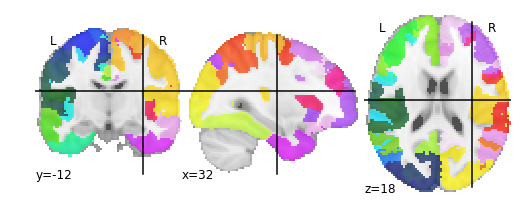

In [3]:
from nilearn import datasets
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir='/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)  # 4D data
from nilearn import plotting
plotting.plot_roi(atlas_filename)

In [44]:
import numpy as np
schaefer_coords = np.loadtxt('data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv', delimiter = ',', skiprows=2, usecols=(2,3,4))
schaefer_coords = tuple(map(tuple, schaefer_coords))
schaefer_coords[:5]


((-36.0, -62.0, -16.0),
 (-24.0, -72.0, -10.0),
 (-36.0, -82.0, -16.0),
 (-16.0, -86.0, -16.0),
 (-24.0, -96.0, -12.0))

### Load task data for MemMatch2 
Right now, I'm only using the second run for testing and because I'm hoping the second run is less sensitive to warm-up effects and memory deterioration from elapsed time.

In [49]:
from nipype.interfaces.io import DataFinder
import os
data_dir = '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep'
os.path.isdir(data_dir)

df = DataFinder()
df.inputs.root_paths = data_dir
df.inputs.match_regex = 'MemMatch2.+preproc_bold.nii.gz'
df_result = df.run()
fmri_filenames = df_result.outputs.out_paths

conf = DataFinder()
conf.inputs.root_paths = data_dir
conf.inputs.match_regex = 'MemMatch2.+regressors.tsv'
conf_result = conf.run()
conf_filenames = conf_result.outputs.out_paths

AttributeError: 'NoneType' object has no attribute 'keys'

### Extract timeseries
I'm detrending the data and applying a bandpass filter from 0.08 to 0.1 Hz. Timeseries are organized into an array with all subjects (pooled_subjects), as well as by age group (oa_subjects, ya_subjects).

Running this for the whole dataset will take some time, so take a coffee break :)

In [5]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, detrend=True, verbose=5, low_pass=0.1, high_pass=0.08, t_r=1.5)

oa_subjects = []
ya_subjects = []
pooled_subjects = []
oa_list = []
ya_list = []
for fmri_file, confound_file in zip(fmri_filenames, conf_filenames):
    time_series = masker.fit_transform(fmri_file, confounds=None) #change to use motion regressors later
    pooled_subjects.append(time_series)
    partic = fmri_file.split('sub-',1)[1]
    partic = partic[0:5]
    if int(partic) >= 40000:
        oa_subjects.append(time_series)
        oa_list.append(partic)
    else:
        ya_subjects.append(time_series)
        ya_list.append(partic)
    print('Data has {0} OA subjects.'.format(len(oa_subjects)))
    print('Data has {0} YA subjects.'.format(len(ya_subjects)))

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 1 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30008/func/sub-30008_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 2 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30009/func/sub-30009_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 3 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30012/func/sub-30012_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 4 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30015/func/sub-30015_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 5 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30019/func/sub-30019_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 6 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30020/func/sub-30020_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 7 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30023/func/sub-30023_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 8 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30040/func/sub-30040_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 9 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30057/func/sub-30057_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 10 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30064/func/sub-30064_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 11 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30066/func/sub-30066_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 12 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30069/func/sub-30069_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 13 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30074/func/sub-30074_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 14 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30085/func/sub-30085_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 15 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30088/func/sub-30088_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 16 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30091/func/sub-30091_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 17 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30095/func/sub-30095_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 18 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30096/func/sub-30096_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 19 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30105/func/sub-30105_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 20 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30116/func/sub-30116_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 21 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30118/func/sub-30118_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 22 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30119/func/sub-30119_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 23 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30128/func/sub-30128_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 24 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30181/func/sub-30181_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 25 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30217/func/sub-30217_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 26 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30227/func/sub-30227_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 27 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30236/func/sub-30236_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 28 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30242/func/sub-30242_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 29 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30274/func/sub-30274_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 30 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30330/func/sub-30330_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 31 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30346/func/sub-30346_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 32 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30400/func/sub-30400_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 33 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30403/func/sub-30403_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 34 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30412/func/sub-30412_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 35 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30426/func/sub-30426_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 36 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30432/func/sub-30432_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 37 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30466/func/sub-30466_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 38 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30469/func/sub-30469_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 39 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30476/func/sub-30476_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 40 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30478/func/sub-30478_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 41 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30568/func/sub-30568_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 42 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30570/func/sub-30570_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 43 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30581/func/sub-30581_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 44 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30584/func/sub-30584_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40160/func/sub-40160_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 1 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40170/func/sub-40170_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 2 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40175/func/sub-40175_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 3 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40288/func/sub-40288_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 4 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40351/func/sub-40351_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 5 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40490/func/sub-40490_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 6 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40496/func/sub-40496_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 7 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40500/func/sub-40500_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 8 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40512/func/sub-40512_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 9 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40515/func/sub-40515_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 10 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40516/func/sub-40516_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 11 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40519/func/sub-40519_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 12 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40520/func/sub-40520_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 13 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40522/func/sub-40522_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 14 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40524/func/sub-40524_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 15 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40547/func/sub-40547_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 16 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40550/func/sub-40550_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 17 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40564/func/sub-40564_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 18 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40601/func/sub-40601_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 19 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40608/func/sub-40608_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 20 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40615/func/sub-40615_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 21 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40619/func/sub-40619_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 22 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40623/func/sub-40623_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 23 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40629/func/sub-40629_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 24 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40638/func/sub-40638_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 25 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40650/func/sub-40650_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 26 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40655/func/sub-40655_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 27 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40656/func/sub-40656_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 28 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40658/func/sub-40658_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 29 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40664/func/sub-40664_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 30 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40665/func/sub-40665_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 31 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40672/func/sub-40672_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 32 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40685/func/sub-40685_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 33 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40694/func/sub-40694_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 34 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40720/func/sub-40720_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 35 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40728/func/sub-40728_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 36 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40730/func/sub-40730_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 37 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40738/func/sub-40738_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 38 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40750/func/sub-40750_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 39 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40758/func/sub-40758_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 40 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40767/func/sub-40767_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 41 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40769/func/sub-40769_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 42 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40777/func/sub-40777_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 43 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40778/func/sub-40778_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 44 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40779/func/sub-40779_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 45 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40784/func/sub-40784_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 46 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40803/func/sub-40803_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 47 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [24]:
#np.save('oa_subjects', oa_subjects)
#np.save('ya_subjects', ya_subjects)
oa_subjects = np.load('data/oa_subjects.npy')
ya_subjects = np.load('data/ya_subjects.npy')

### Calculate functional connectivity using full correlation

In [25]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

correlation_matrices_oa = correlation_measure.fit_transform(oa_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of OA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_oa.shape))

mean_correlation_matrix_oa = correlation_measure.mean_
print('Mean correlation OA has shape {0}.'.format(mean_correlation_matrix_oa.shape))

Correlations of OA patients are stacked in an array of shape (47, 400, 400)
Mean correlation OA has shape (400, 400).


In [21]:
#np.save('correlation_matrices_oa', correlation_matrices_oa)

NameError: name 'correlation_measure' is not defined

In [26]:
correlation_matrices_ya = correlation_measure.fit_transform(ya_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of YA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_ya.shape))

mean_correlation_matrix_ya = correlation_measure.mean_
print('Mean correlation YA has shape {0}.'.format(mean_correlation_matrix_ya.shape))

Correlations of YA patients are stacked in an array of shape (45, 400, 400)
Mean correlation YA has shape (400, 400).


In [16]:
#np.save('correlation_matrices_ya', correlation_matrices_ya)

### Plot correlation matrices for a handful of subjects

In [4]:
import numpy as np
correlation_matrices_oa = np.load('data/correlation_matrices_oa.npy')
correlation_matrices_ya = np.load('data/correlation_matrices_ya.npy')
print(len(correlation_matrices_oa))

47


In [27]:
import matplotlib.pylab as plt

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

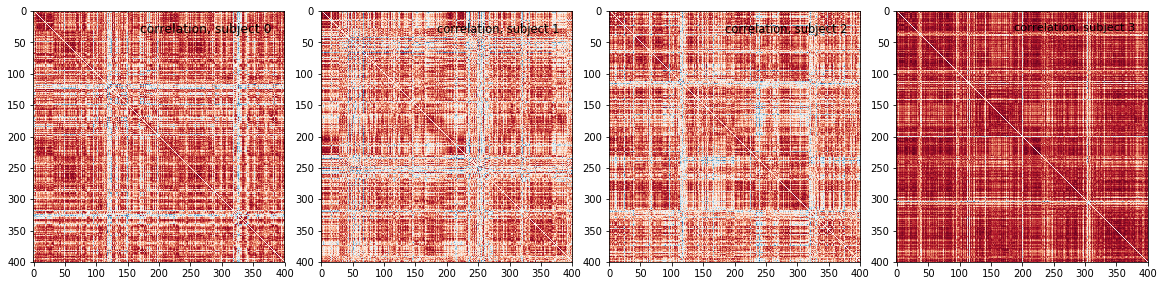

In [42]:
plot_matrices(correlation_matrices_oa[:4], 'correlation')

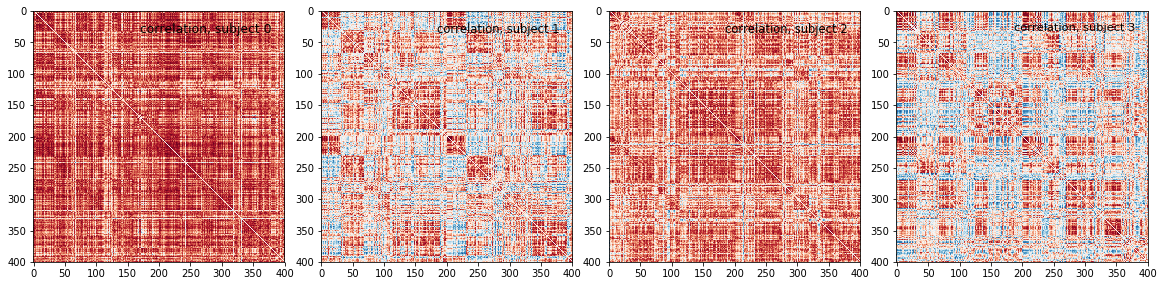

In [36]:
plot_matrices(correlation_matrices_ya[:4], 'correlation')

### Visualize group mean correlation matrices on glass brain

Another good time for a coffee break :)

It's really hard to see the edges since I can't find a way to only show nodes with significant edges.

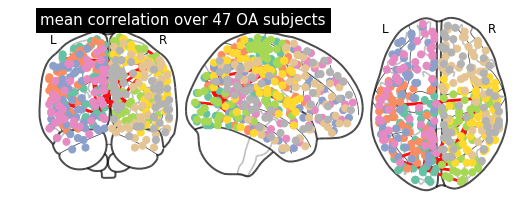

In [45]:
from nilearn import plotting

plotting.plot_connectome(mean_correlation_matrix_oa, schaefer_coords, title='mean correlation over {0} OA subjects'.format(len(correlation_matrices_oa)), edge_threshold=0.80)


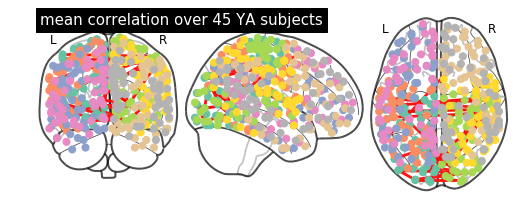

In [46]:
plotting.plot_connectome(mean_correlation_matrix_ya, schaefer_coords, title='mean correlation over {0} YA subjects'.format(len(correlation_matrices_ya)), edge_threshold=0.80)


### ICA

This code is from [an ICA example](https://nilearn.github.io/connectivity/resting_state_networks.html) on the Nilearn website.

In [47]:
from nilearn.decomposition import CanICA

canica = CanICA(n_components=20, smoothing_fwhm=6.,
                threshold=3., verbose=10, random_state=0)
canica.fit(fmri_filenames)

components_img = canica.components_img_

components_img.to_filename('data/canica_memmatch2.nii.gz')

NameError: name 'fmri_filenames' is not defined

In [ ]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')

In [ ]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)

show()

### Use the Network-Based Statistic to analyze group functional connectivity differences

Read more about NBS in [Zalesky (2010)](10.1016/j.neuroimage.2010.06.041).

This uses the [Brain Connectivity Toolbox for Python](https://github.com/aestrivex/bctpy).

    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)

In [5]:
from bct import nbs

X = correlation_matrices_ya.reshape((400, 400, len(correlation_matrices_ya)))
Y = correlation_matrices_oa.reshape((400, 400, len(correlation_matrices_oa)))

pval, adj, null = nbs.nbs_bct(X, Y, thresh=10.0, k=3, tail='right', paired=False, verbose=False)


max component size is 4839
estimating null distribution with 3 permutations
permutation 0 of 3.  p-value so far is 0.000
permutation 2 of 3.  p-value so far is 0.000


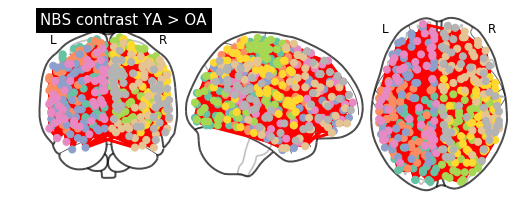

In [13]:
from nilearn import plotting
plotting.plot_connectome(adj, schaefer_coords, title='NBS contrast YA > OA')

In [53]:
pval, adj, null = nbs.nbs_bct(X, Y, thresh=10.0, k=3, tail='left', paired=False, verbose=False)

max component size is 20453
estimating null distribution with 3 permutations
permutation 0 of 3.  p-value so far is 0.000
permutation 2 of 3.  p-value so far is 0.000


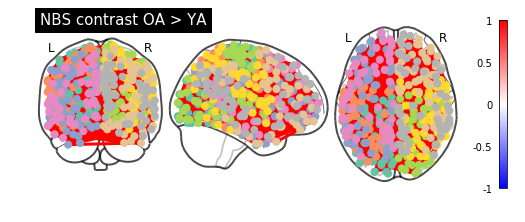

In [19]:
plotting.plot_connectome(adj, schaefer_coords, title='NBS contrast OA > YA')